# Лабораторная работа 2. Решение систем линейных алгебраических уравнений.

#### Цель работы:

1. Оценить число обусловленности системы.
2. Решить систему линейных алгебраических уравнений методами Гаусса с выбором главного элемента, Зейделя, Якоби, верхней релаксации. 
3. Найти степенным методом максимальное и минимальное собственные числа.

<img src="images/system.png" alt="Система линейных алгебраических уравнений. См Labs/Lab 2. */images/system.png" width="400"/>

In [134]:
import sys
import numpy
import os
import math
import itertools
import random
import matplotlib.pyplot as plt

### Функции

In [2]:
def MakeDiagonal(A, f):
    for rowIndex in range(len(A)-1, -1, -1):
        columnIndex = rowIndex

        # Уже сделали это в MakeUpDiagonal.
        #f[rowIndex] /= A[rowIndex][columnIndex]
        #A[rowIndex][columnIndex] = 1

        for _rowIndex in range(0, rowIndex):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex][columnIndex] = 0

def MakeUpDiagonal(A, f, findMaxElem):
    for columnIndex in range(0, len(A)):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                if (A[_rowIndex][columnIndex] > maxElem):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                f[[rowIndex, maxRowIndex]] = f[[maxRowIndex, rowIndex]]

        # Прямой ход метода Гаусса.

        # Делаем диагональный элемент равным 1.
        a = A[rowIndex][columnIndex]
        A[rowIndex] /= a
        f[rowIndex] /= a
        # Присваиваем точное значение, из-за возможной ошибки при округлении.
        A[rowIndex][columnIndex] = 1
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex] -= A[rowIndex] * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
 
# Решает систему линейных уравнений Ax = f методом Гаусса. 
# Внимание! Изменяет исходные значения A и f.
def SolveGauss(A, f, findMaxElem = True):
    MakeUpDiagonal(A, f, findMaxElem)
    MakeDiagonal(A, f)
    return f

# Находит ошибку решения системы уравнений: residual = Af - s.
def CheckSystemSolution(A, f, s):
    residual = numpy.empty(len(A))
    for rowIndex in range(0, len(A)):
        residual[rowIndex] = numpy.dot(A[rowIndex], s) - f[rowIndex]
    return residual

In [3]:
# Вычисление детерминанта по формуле разложения по строке.
# Медленно работает из-за постоянного выделения памяти для миноров.
def MatrixDeterminantVeryVerySlow(A):
    if (len(A) == 1):
        return A[0][0]
    if (len(A) == 2):
        return A[0][0] * A[1][1] - A[1][0] * A[0][1]
    
    det = 0
    sign = 1
    for columnIndex in range(0, len(A)):
        cols = numpy.array(list(range(0, columnIndex)) + list(range(columnIndex + 1, len(A))))
        rows = numpy.arange(1, len(A))
        minor = A[cols[:,numpy.newaxis], rows]
        det += sign * A[0][columnIndex] * MatrixDeterminantVeryVerySlow(minor)
        sign = -sign
    return det

# Методом Гаусса приводим к верхне-диагональному виду, затем находим определить как произведение диагональных элементов верхне-треугольной матрицы.
def MatrixDeterminant1(A, findMaxElem):
    det = 1
    # От первой до предпоследней строки. Последняя строка уже приведена к нужному виду.
    for columnIndex in range(0, len(A) - 1):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        # Строки матрицы можно переставлять, значение определителя поменяет знак.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                if (A[_rowIndex][columnIndex] > maxElem):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                det = -det

        # Прямой ход метода Гаусса.
        a = A[rowIndex] / A[rowIndex][columnIndex]
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            A[_rowIndex] -= a * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
        # Детерминант равен произведению диагональных элементов.
        det *= A[rowIndex][columnIndex]
    det *= A[len(A) - 1, len(A) - 1]
    return det

# Вычисление детерминанта по формуле полного разложения (через перестановки) слишком вычислительно затратный.
# Для формулы полного разложения 100! ~9,332621544×10^157 - слишком большое число. 
# В тоже время метод Гаусса требует ~(2/3 * 100^3 + 100^2) итераций - что приемлемо.

# Нахождение обратной матрицы методом Гаусса.
# Не изменяет исходную матрицу A.
def MatrixInverse1(A):
    invA = numpy.identity(len(A))
    srcA = numpy.empty((len(A), len(A)))
    numpy.copyto(srcA, A)

    MakeUpDiagonal(srcA, invA, False)
    MakeDiagonal(srcA, invA)
    return invA

def MatrixInverse3(A):
    return numpy.linalg.inv(A)

In [48]:
def NormV1(x):
    return numpy.max(numpy.abs(x))

def NormV2(x):
    return numpy.sum(numpy.abs(x))

def NormV3(x):
    return math.sqrt(numpy.dot(x, x))

def NormM1(A):
    # Максимальная сумма по строке модулей элементов.
    result = 0
    for rowIndex in range(0, len(A)):
        sum = 0
        for columnIndex in range(0, len(A)):
            sum += abs(A[rowIndex][columnIndex])
        if (sum > result):
            result = sum
    return result

def NormM2(A):
    # Максимальная сумма по столбцам модулей элементов.
    result = 0
    for columnIndex in range(0, len(A)):
        sum = 0
        for rowIndex in range(0, len(A)):
            sum += abs(A[rowIndex][columnIndex])
        if (sum > result):
            result = sum
    return result

In [174]:
def GetLDU(A):
    D = numpy.zeros((len(A), len(A)))
    L = numpy.zeros((len(A), len(A)))
    U = numpy.zeros((len(A), len(A)))
    
    D[0][0] = A[0][0]
    for st1 in range(1, len(A)):
        for st2 in range(0, st1):
            L[st1][st2] = A[st1][st2]
            U[st2][st1] = A[st2][st1]
        D[st1][st1] = A[st1][st1]
    return (L, D, U)

def SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters):
    sn = numpy.empty(len(M1))
    numpy.copyto(sn, s0)
    iterNum = 1
    while (True):
        f1  = numpy.dot(M1, sn)
        sn1 = f1 + f2
        r   = norm(sn1 - sn)
        sn = sn1

        if (residuals is not None):
            residuals.append(r)

        if (r < eps):
            return sn
        
        iterNum += 1
        if (iterNum > maxIters):
            return sn

def SolveRelaxation(A, f, s0, eps, tau, norm, residuals : list = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M1 = numpy.dot(
        -MatrixInverse3(D + tau * L),
        (tau - 1) * D + tau * U)
    f2 = numpy.dot(tau * MatrixInverse3(D + tau * L), f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

def SolveSeidel(A, f, s0, eps, norm, residuals : list = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M2 = MatrixInverse1(L + D)
    M1 = -numpy.dot(M2, U)
    f2 = numpy.dot(M2, f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

def SolveJacob(A, f, s0, eps, norm, residuals = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M2 = MatrixInverse1(D)
    M1 = -numpy.dot(M2, L + U)
    f2 = numpy.dot(M2, f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

### Сравнение вычисления детерминанта матрицы с выбором максимального элемента и без.

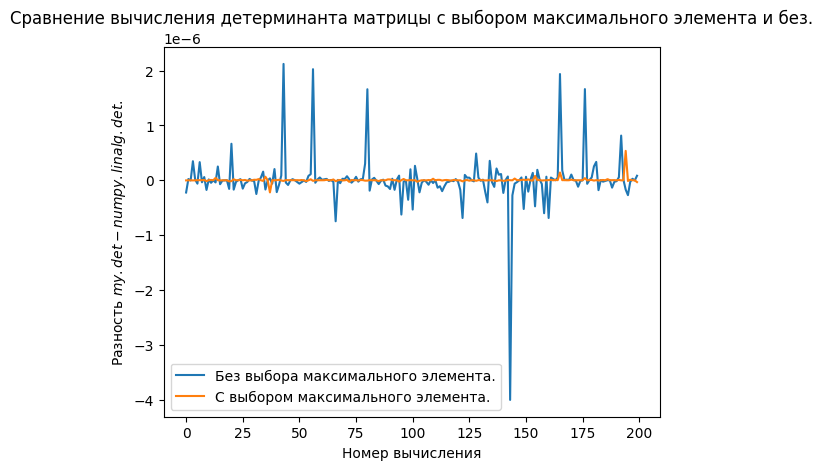

Text(0.5, 1.0, 'Сравнение вычисления детерминанта матрицы с выбором максимального элемента.')

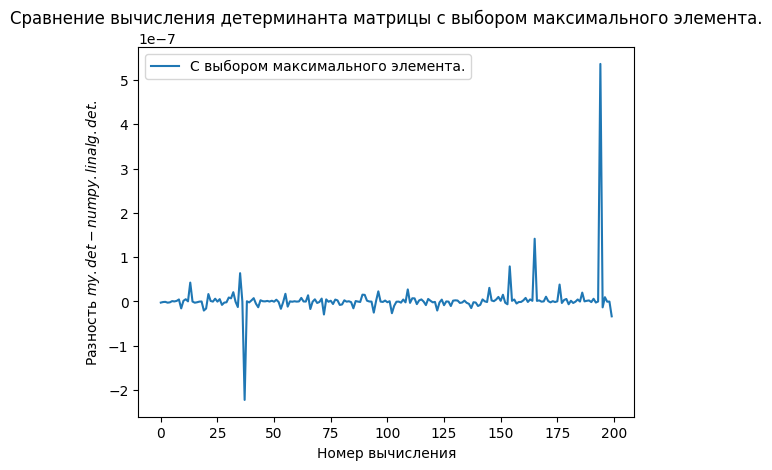

In [11]:
x1 = []
x2 = []
samples = 200
for st in range(0, samples):
    size = 50
    A2 = numpy.random.rand(size, size)
    
    _A = numpy.empty((size, size))
    numpy.copyto(_A, A2)
    det1 = MatrixDeterminant1(_A, False)

    _A = numpy.empty((size, size))
    numpy.copyto(_A, A2)
    det2 = MatrixDeterminant1(_A, True)

    det3 = numpy.linalg.det(A2)
    x1.append(det1 - det3)
    x2.append(det2 - det3)

plt.plot(list(range(0, samples)), x1, label="Без выбора максимального элемента.")
plt.plot(list(range(0, samples)), x2, label="С выбором максимального элемента.")

plt.legend()
plt.xlabel("Номер вычисления")
plt.ylabel("Разность $my.det - numpy.linalg.det$.")
plt.title("Сравнение вычисления детерминанта матрицы с выбором максимального элемента и без.")
plt.show()

plt.plot(list(range(0, samples)), x2, label="С выбором максимального элемента.")

plt.legend()
plt.xlabel("Номер вычисления")
plt.ylabel("Разность $my.det - numpy.linalg.det$.")
plt.title("Сравнение вычисления детерминанта матрицы с выбором максимального элемента.")

### Вычисление обратной матрицы

Text(0.5, 1.0, 'Сравнение алгоритмов вычисления обратных матриц. $inv_1$ -- метод Гаусса, $inv_3$ -- numpy.linalg.inv(A).')

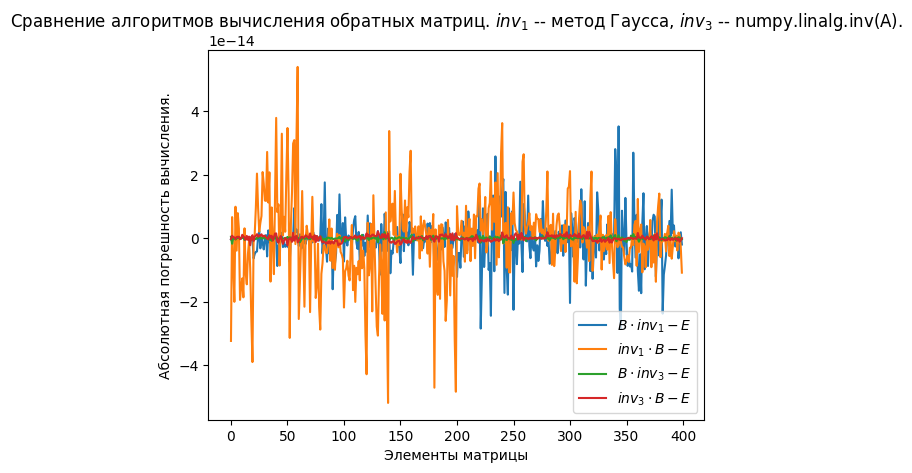

In [5]:
size = 20
B = numpy.random.rand(size, size)
E = numpy.identity(size)

inv1 = MatrixInverse1(B)
inv3 = MatrixInverse3(B)

if (False):
    print("Матрица\n", B)
    print("Обратная матрица, метод Гаусса\n", inv1)
    print("Обратная матрица, numpy.linalg.inv(A)\n", inv3)

r1_1 = (numpy.dot(B, inv1) - E).ravel().tolist()
r1_2 = (numpy.dot(inv1, B) - E).ravel().tolist()
r3_1 = (numpy.dot(B, inv3) - E).ravel().tolist()
r3_2 = (numpy.dot(inv3, B) - E).ravel().tolist()

num = list(range(0, len(r1_1)))

plt.plot(num, r1_1, label="$B \cdot inv_1 - E$")
plt.plot(num, r1_2, label="$inv_1 \cdot B - E$")
plt.plot(num, r3_1, label="$B \cdot inv_3 - E$")
plt.plot(num, r3_2, label="$inv_3 \cdot B - E$")

plt.legend()
plt.xlabel("Элементы матрицы")
plt.ylabel("Абсолютная погрешность вычисления.")
plt.title("Сравнение алгоритмов вычисления обратных матриц. $inv_1$ -- метод Гаусса, $inv_3$ -- numpy.linalg.inv(A).")

### Метод Гаусса

In [6]:
f = numpy.array([100 - st for st in range (0, 100)])
A = numpy.zeros((100, 100), dtype = float)

# Первая строка
for st in range(0, 100):
    A[0][st] = 1
    pass
# Середина по 3 элемента.
for rowIndex in range(1, 99):
    A[rowIndex][rowIndex - 1] = 1
    A[rowIndex][rowIndex    ] = 10
    A[rowIndex][rowIndex + 1] = 1
    pass
# Последняя строка.
A[99][98] = 1
A[99][99] = 1

print(A)

[[ 1.  1.  1. ...  1.  1.  1.]
 [ 1. 10.  1. ...  0.  0.  0.]
 [ 0.  1. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10.  1.  0.]
 [ 0.  0.  0. ...  1. 10.  1.]
 [ 0.  0.  0. ...  0.  1.  1.]]


Text(0.5, 1.0, 'Метод Гаусса. Матрица из задачника. С выбором главного элемента.')

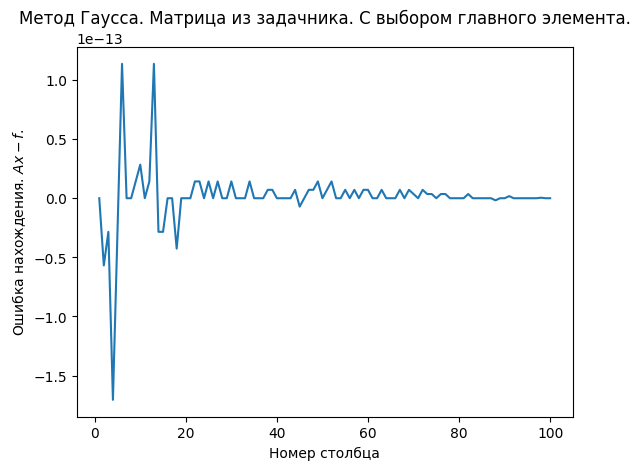

In [7]:
_A = numpy.empty((100, 100))
_f = numpy.empty(100)
numpy.copyto(_A, A)
numpy.copyto(_f, f)
s = SolveGauss(_A, _f, True)
residual = CheckSystemSolution(A, f, s)

plt.plot(numpy.arange(1, len(A) + 1), residual)
plt.xlabel("Номер столбца")
plt.ylabel("Ошибка нахождения. $Ax - f$.")
plt.title("Метод Гаусса. Матрица из задачника. С выбором главного элемента.")

Text(0.5, 1.0, 'Метод Гаусса. Случайная матрица.')

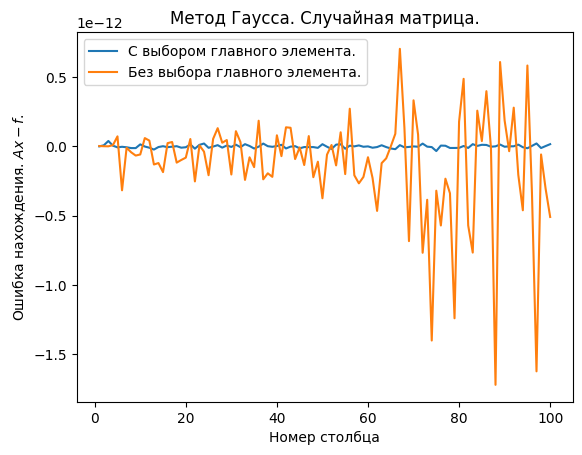

In [8]:
size1 = 100
A1 = numpy.random.rand(size1, size1)
f1 = numpy.random.rand(size1)

_A = numpy.empty((size1, size1))
_f = numpy.empty(size1)
numpy.copyto(_A, A1)
numpy.copyto(_f, f1)

s = SolveGauss(_A, _f, True)
r = CheckSystemSolution(A1, f1, s)

if (False):
    print("Матрица\n", A1)
    print("Вектор свободных коэффициентов\n", f1)
    print("Решение\n", s)
    print("Ошибка решения\n", r)

plt.plot(numpy.arange(1, len(A1) + 1), r, label = "С выбором главного элемента.")

_A = numpy.empty((size1, size1))
_f = numpy.empty(size1)
numpy.copyto(_A, A1)
numpy.copyto(_f, f1)

s = SolveGauss(_A, _f, False)
r = CheckSystemSolution(A1, f1, s)

plt.plot(numpy.arange(1, len(A1) + 1), r, label = "Без выбора главного элемента.")

plt.legend()
plt.xlabel("Номер столбца")
plt.ylabel("Ошибка нахождения. $Ax - f$.")
plt.title("Метод Гаусса. Случайная матрица.")

### Метод Зейделя.

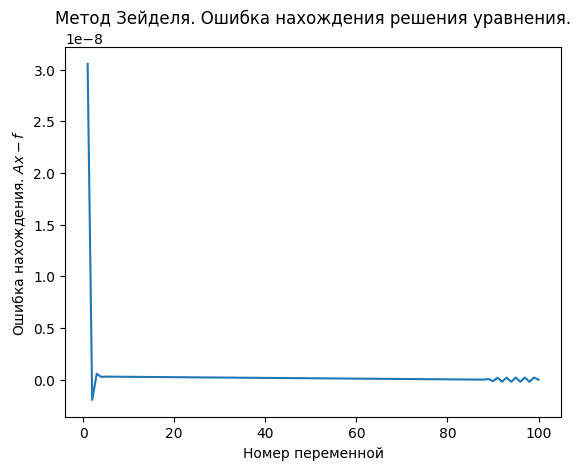

Text(0.5, 1.0, 'Метод Зейделя. Убывание невязки в 1 норме.')

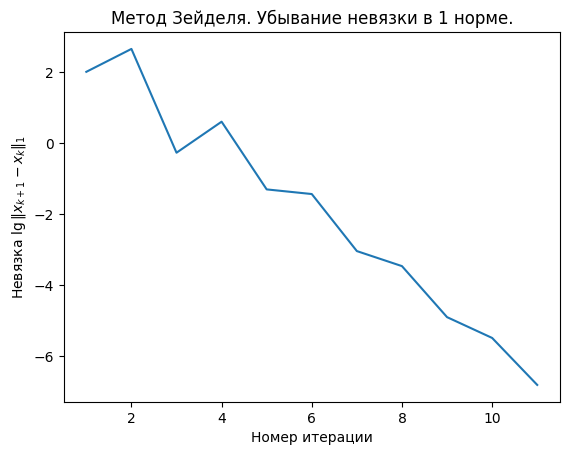

In [97]:
residuals = []
solution = SolveSeidel(A, f, numpy.zeros(len(A)), 1e-6, NormV1, residuals)

r = numpy.dot(A, solution) - f
plt.plot(numpy.arange(1, len(r) + 1), r)

plt.xlabel("Номер переменной")
plt.ylabel("Ошибка нахождения. $Ax - f$")
plt.title("Метод Зейделя. Ошибка нахождения решения уравнения.")
plt.show()

plt.plot(numpy.arange(1, len(residuals) + 1), numpy.log10(residuals))

plt.xlabel("Номер итерации")
plt.ylabel("Невязка $\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод Зейделя. Убывание невязки в 1 норме.")

### Метод Якоби

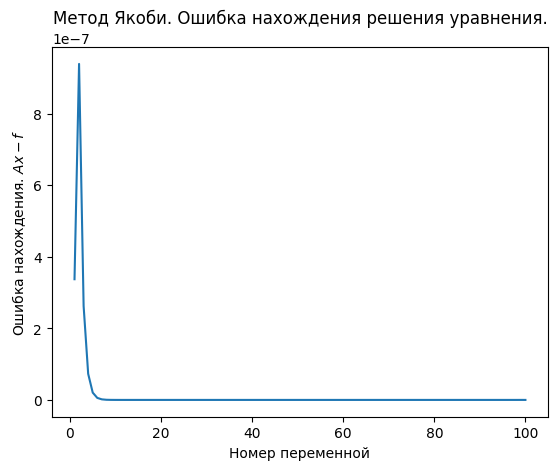

Text(0.5, 1.0, 'Метод Якоби. Убывание невязки в 1 норме.')

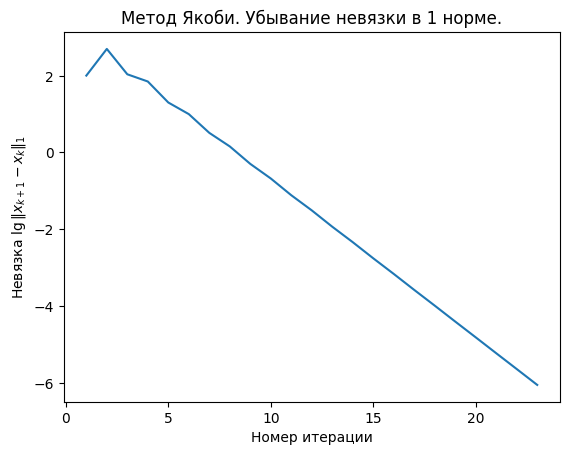

In [110]:
residuals = []
solution = SolveJacob(A, f, numpy.zeros(len(A)), 1e-6, NormV1, residuals)
jacobSolution = solution
r = numpy.dot(A, solution) - f
plt.plot(numpy.arange(1, len(r) + 1), r)

plt.xlabel("Номер переменной")
plt.ylabel("Ошибка нахождения. $Ax - f$")
plt.title("Метод Якоби. Ошибка нахождения решения уравнения.")
plt.show()

plt.plot(numpy.arange(1, len(residuals) + 1), numpy.log10(residuals))

plt.xlabel("Номер итерации")
plt.ylabel("Невязка $\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод Якоби. Убывание невязки в 1 норме.")

### Метод верхней релаксации.

Если итерационный параметр $\tau$ равен 1, то метод вырождается в метод Зейделя. Для $\tau$ в интервале (1; 2) метод сходится дольше, чем метод Зейделя. При $\tau$ больше 2 или меньше 0, метод расходится.

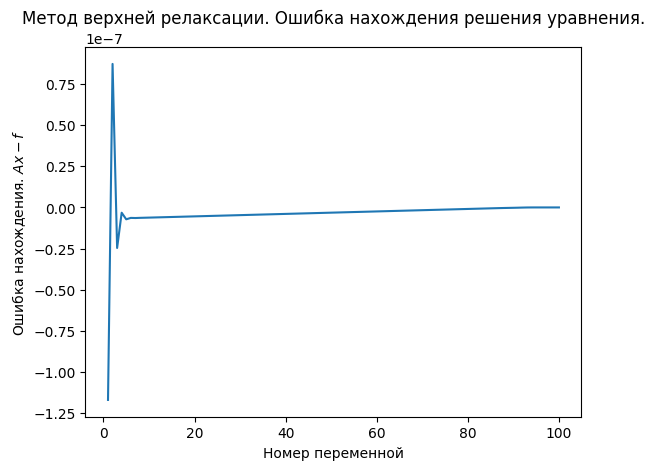

Text(0.5, 1.0, 'Метод верхней релаксации. Убывание невязки в 1 норме.')

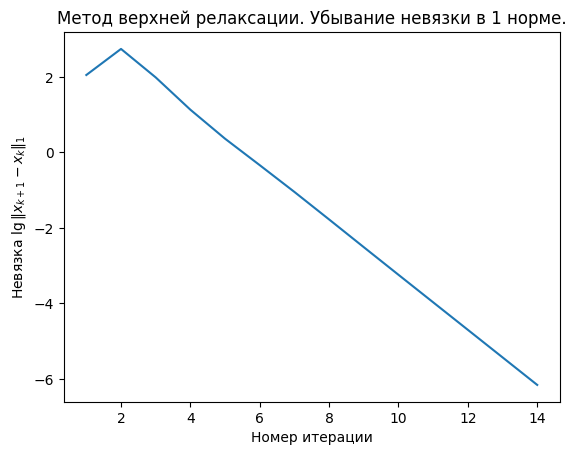

In [133]:
residuals = []
solution = SolveRelaxation(A, f, numpy.zeros(len(A)), 1e-6, 1.1, NormV1, residuals)

r = numpy.dot(A, solution) - f
plt.plot(numpy.arange(1, len(r) + 1), r)

plt.xlabel("Номер переменной")
plt.ylabel("Ошибка нахождения. $Ax - f$")
plt.title("Метод верхней релаксации. Ошибка нахождения решения уравнения.")
plt.show()

plt.plot(numpy.arange(1, len(residuals) + 1), numpy.log10(residuals))

plt.xlabel("Номер итерации")
plt.ylabel("Невязка $\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод верхней релаксации. Убывание невязки в 1 норме.")

### Метод Якоби, Зейделя, верхней релаксации для случайной системы

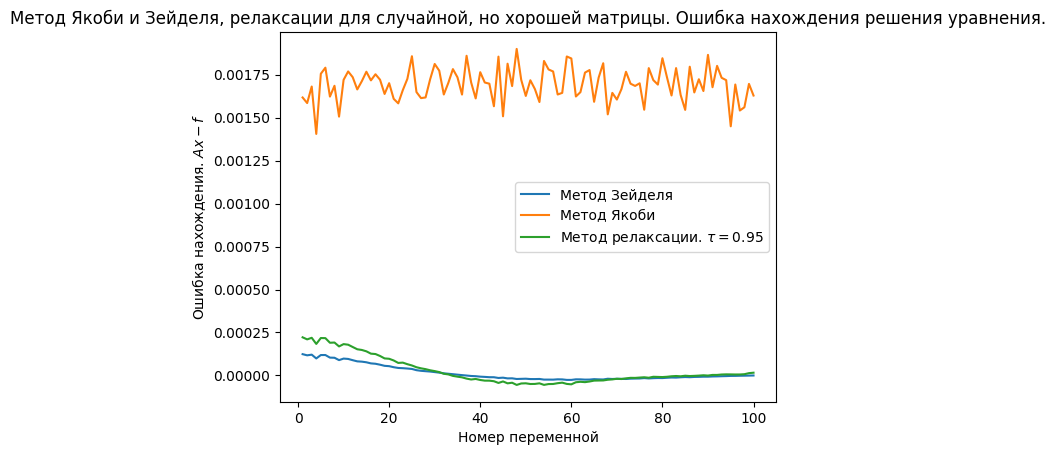

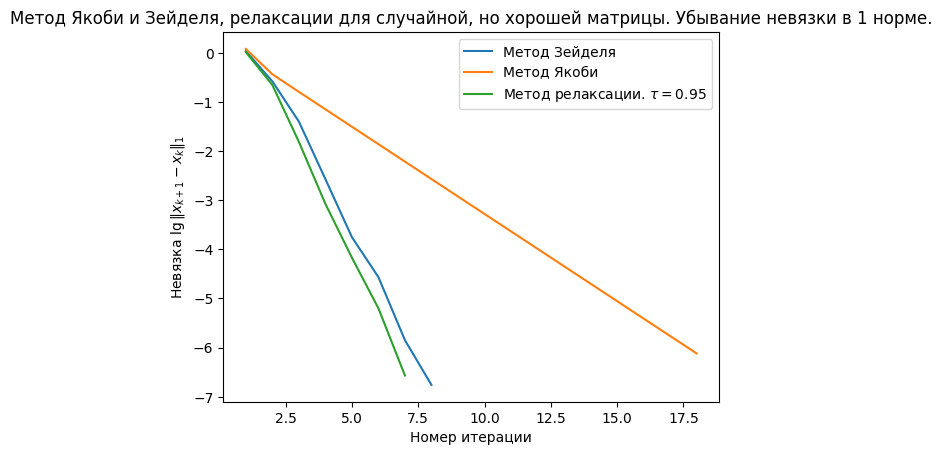

In [175]:
size1 = 100

A1 = numpy.random.rand(size1, size1)
# Делаем матрицу симметричной, чтобы метод Зейделя сходился чаще (почти достаточное условие. Возможно не выполнена положительная определённость и метод разойдется).
A1 = numpy.dot(numpy.transpose(A1), A1)
# Условие диагонального преобладания => метод Якоби сходится (достаточное условие).
melem = (numpy.max(A1) + abs(numpy.min(A1))) * size1
for st in range(0, size1):
    A1[st][st] = melem

f1 = numpy.random.rand(size1)
x0 = numpy.random.random(size1)

residuals1 = []
residuals2 = []
residuals3 = []
solution1 = SolveSeidel(A1, f1, x0, 1e-6, NormV1, residuals1)
solution2 = SolveJacob(A1, f1, x0, 1e-6, NormV1, residuals2)
tau = random.uniform(1 + 1e-10, 2 - 1e-10)
tau = 0.95
solution3 = SolveRelaxation(A1, f1, x0, 1e-6, tau, NormV1, residuals3)

r1 = numpy.dot(A1, solution1) - f1
r2 = numpy.dot(A1, solution2) - f1
r3 = numpy.dot(A1, solution3) - f1

plt.plot(numpy.arange(1, len(r1) + 1), r1, label="Метод Зейделя")
plt.plot(numpy.arange(1, len(r2) + 1), r2, label="Метод Якоби")
plt.plot(numpy.arange(1, len(r3) + 1), r3, label="Метод релаксации. $\\tau = {:.2f}$".format(tau))

plt.legend()
plt.xlabel("Номер переменной")
plt.ylabel("Ошибка нахождения. $Ax - f$")
plt.title("Метод Якоби и Зейделя, релаксации для случайной, но хорошей матрицы. Ошибка нахождения решения уравнения.")
plt.show()

plt.plot(numpy.arange(1, len(residuals1) + 1), numpy.log10(residuals1), label="Метод Зейделя")
plt.plot(numpy.arange(1, len(residuals2) + 1), numpy.log10(residuals2), label="Метод Якоби")
plt.plot(numpy.arange(1, len(residuals3) + 1), numpy.log10(residuals3), label="Метод релаксации. $\\tau = {:.2f}$".format(tau))

plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("Невязка $\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод Якоби и Зейделя, релаксации для случайной, но хорошей матрицы. Убывание невязки в 1 норме.")
plt.show()